In [1]:
import pandas as pd
import quandl, math, datetime
import numpy as np
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib import style
import pickle

style.use('ggplot')

Get data from Quandl

In [2]:
df = quandl.get('WIKI/GOOGL')
df.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2004-08-19,100.01,104.06,95.96,100.335,44659000.0,0.0,1.0,50.159839,52.191109,48.128568,50.322842,44659000.0
2004-08-20,101.01,109.08,100.50,108.310,22834300.0,0.0,1.0,50.661387,54.708881,50.405597,54.322689,22834300.0
2004-08-23,110.76,113.48,109.05,109.400,18256100.0,0.0,1.0,55.551482,56.915693,54.693835,54.869377,18256100.0
2004-08-24,111.24,111.60,103.57,104.870,15247300.0,0.0,1.0,55.792225,55.972783,51.945350,52.597363,15247300.0
2004-08-25,104.76,108.00,103.88,106.000,9188600.0,0.0,1.0,52.542193,54.167209,52.100830,53.164113,9188600.0


Only keep desiried fields

In [3]:
df = df[['Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close', 'Adj. Volume']]

Create ratios/calculations and make final df

In [4]:
df['HL_PCT'] = (df['Adj. High'] - df['Adj. Close']) / df['Adj. Close'] * 100
df['PCT_change'] = (df['Adj. Close'] - df['Adj. Open']) / df['Adj. Open'] * 100

df = df[['Adj. Close', 'HL_PCT', 'PCT_change', 'Adj. Volume']]
df.head()

,Adj. Close,HL_PCT,PCT_change,Adj. Volume
Date,,,,
2004-08-19,50.322842,3.712563,0.324968,44659000.0
2004-08-20,54.322689,0.710922,7.227007,22834300.0
2004-08-23,54.869377,3.729433,-1.227880,18256100.0
2004-08-24,52.597363,6.417469,-5.726357,15247300.0
2004-08-25,53.164113,1.886792,1.183658,9188600.0


Build simple algo

In [5]:
forecast_col = 'Adj. Close'

# Replace NAN values
df.fillna(-99999, inplace=True)

# Forecasting 10% (of the dataset) out
forecast_out = int(math.ceil(0.1*len(df)))

# label column will show future forecasted price at the current date
df['label'] = df[forecast_col].shift(-forecast_out)

df.head()

,Adj. Close,HL_PCT,PCT_change,Adj. Volume,label
Date,,,,,
2004-08-19,50.322842,3.712563,0.324968,44659000.0,214.005615
2004-08-20,54.322689,0.710922,7.227007,22834300.0,210.725489
2004-08-23,54.869377,3.729433,-1.227880,18256100.0,208.072299
2004-08-24,52.597363,6.417469,-5.726357,15247300.0,218.288837
2004-08-25,53.164113,1.886792,1.183658,9188600.0,223.309335


Creating model

In [6]:
# Setting up variables
X = np.array(df.drop(['label'],1))
X = preprocessing.scale(X)
X_lately = X[-forecast_out:]
X = X[:-forecast_out]


df.dropna(inplace=True)
y = np.array(df['label'])

/var/folders/rw/hql3pd214t59q_rc7_7h0lqm0000gn/T/ipykernel_89219/477669748.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = np.array(df.drop(['label'],1))


In [7]:
# Training and testing model 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf = LinearRegression(n_jobs=-1)
clf.fit(X_train, y_train)

# Pickling to save the trained model
with open('linearregression.pickle', 'wb') as f:
    pickle.dump(clf, f)

# Using saved model in PICKLE FILE
pickle_in = open('linearregression.pickle', 'rb')
clf = pickle.load(pickle_in)

accuracy = clf.score(X_test, y_test)

Predicting

In [8]:
forecast_set = clf.predict(X_lately)

Plotting

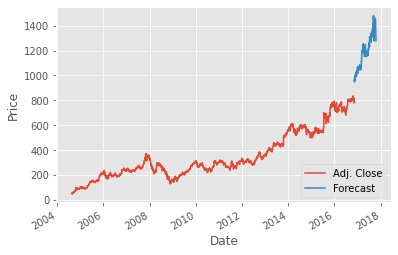

In [9]:
df['Forecast'] = np.nan

last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day

for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += one_day
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)] + [i]

df['Adj. Close'].plot()
df['Forecast'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()